In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [2]:
az.style.use("arviz-white")

# One-way random effects model for the jaw data

### Chapter 4.4: Random effects

Let $Y_{ij}$ be the $j^{th}$ measurement of jaw bone density for patient $i$. The one-way random effects model is

$$Y_{ij}|\alpha_i\sim\mbox{Normal}(\alpha_i,\sigma^2)\mbox{   where   }\alpha_i\sim\mbox{Normal}(\mu,\tau^2).$$

The random effect $\alpha_i$ is the true mean for patient $i$, and the observations for patient $i$ vary around $\alpha_i$ with variance $\sigma^2$.  In this model, the population of patient-specific means is assumed to follow a normal distribution with mean $\mu$ and variance $\tau^2$.  The hyperparameters have uninformative prior $\mu\sim\mbox{Normal}(0,1000)$, $\sigma^2\sim\mbox{InvGamma}(0.1,0.1)$, and $\tau^2\sim\mbox{InvGamma}(0.1,0.1)$.

The objective is to borrow strength across patients to estimate the mean for each patient, $\alpha_i$, and to estimate the overall population mean $\mu$.


## Load and plot the data

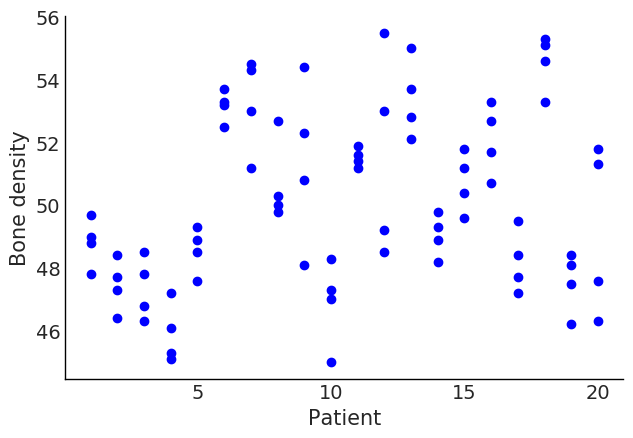

In [3]:
# fmt: off
Y   = np.array([47.8, 48.8, 49.0, 49.7,
      46.4, 47.3, 47.7, 48.4,
      46.3, 46.8, 47.8, 48.5,
      45.1, 45.3, 46.1, 47.2,
      47.6, 48.5, 48.9, 49.3,
      52.5, 53.2, 53.3, 53.7,
      51.2, 53.0, 54.3, 54.5,
      49.8, 50.0, 50.3, 52.7,
      48.1, 50.8, 52.3, 54.4,
      45.0, 47.0, 47.3, 48.3,
      51.2, 51.4, 51.6, 51.9,
      48.5, 49.2, 53.0, 55.5,
      52.1, 52.8, 53.7, 55.0,
      48.2, 48.9, 49.3, 49.8,
      49.6, 50.4, 51.2, 51.8,  
      50.7, 51.7, 52.7, 53.3,
      47.2, 47.7, 48.4, 49.5,
      53.3, 54.6, 55.1, 55.3,
      46.2, 47.5, 48.1, 48.4,
      46.3, 47.6, 51.3, 51.8]).reshape(20, 4)
# fmt: on

plt.plot(Y, "bo")
plt.xticks(range(4, 20, 5), range(5, 21, 5))
plt.xlabel("Patient")
plt.ylabel("Bone density");

In [4]:
with pm.Model() as model:
    # Priors
    μ = pm.Normal("μ", 0, 1000)
    τa = pm.Gamma("τa", 0.1, 0.1)
    τe = pm.Gamma("τe", 0.1, 0.1)
    # Random effects
    α = pm.Normal("α", μ, τa, shape=20)
    # likelihood
    y_obs = pm.Normal("y_obs", α, τe, observed=Y.T)
    samples = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, τe, τa, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 820.03draws/s] 


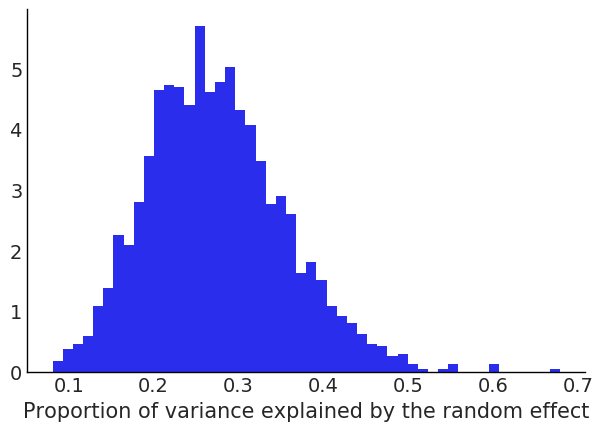

In [5]:
lala = samples["τe"] ** 2 / (samples["τa"] ** 2 + samples["τe"] ** 2)
plt.hist(lala, bins=50, density=True)
plt.xlabel("Proportion of variance explained by the random effect");

## Random-effect estimates

The plots the posterior of each subject's random effect, $\alpha_i$, as a boxplot. The data $Y_{ij}$ are overlain as points.

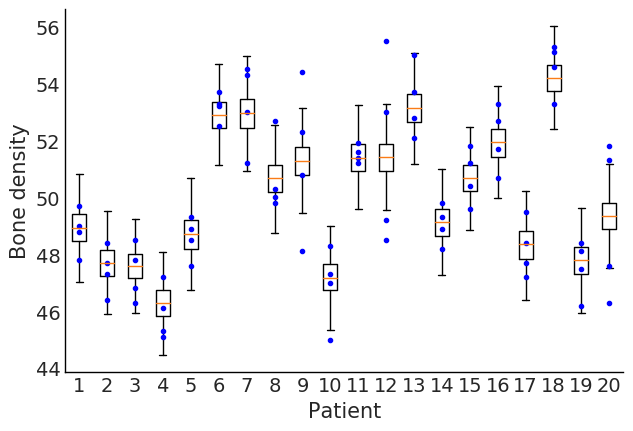

In [6]:
plt.boxplot(samples["α"], showfliers=False)
plt.plot(range(1, 21), Y, "b.")
plt.xlabel("Patient")
plt.ylabel("Bone density");

## Fit the one-way random effects model with half-Cauchy priors

In [7]:
with pm.Model() as model_c:
    # Priors
    μ = pm.Normal("μ", 0, 1000)
    τa = pm.HalfCauchy("τa", 1)
    τe = pm.HalfCauchy("τe", 1)
    # Random effects
    α = pm.Normal("α", μ, τa, shape=20)
    # likelihood
    y_obs = pm.Normal("y_obs", α, τe, observed=Y.T)
    samples_c = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, τe, τa, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 798.97draws/s] 
The acceptance probability does not match the target. It is 0.9223486076734269, but should be close to 0.8. Try to increase the number of tuning steps.


## Prior sensitivity

The summaries below compare the posterior distribution of the standard deviation using InvGamma versus half-Cauchy priors. For these data the results are similar for the two priors.

In [8]:
az.summary(
    samples,
    var_names=["τa", "τe"],
    stat_funcs={
        "0.5": lambda x: np.percentile(x, (50)),
        "0.025": lambda x: np.percentile(x, (2.5)),
        "0.975": lambda x: np.percentile(x, (97.5)),
    },
    extend=False,
).T

,τa,τe
0.5,2.429,1.461
0.025,1.736,1.241
0.975,3.497,1.760


In [9]:
az.summary(
    samples_c,
    var_names=["τa", "τe"],
    stat_funcs={
        "0.5": lambda x: np.percentile(x, (50)),
        "0.025": lambda x: np.percentile(x, (2.5)),
        "0.975": lambda x: np.percentile(x, (97.5)),
    },
    extend=False,
).T

,τa,τe
0.5,2.375,1.457
0.025,1.696,1.238
0.975,3.520,1.755


# Error SD

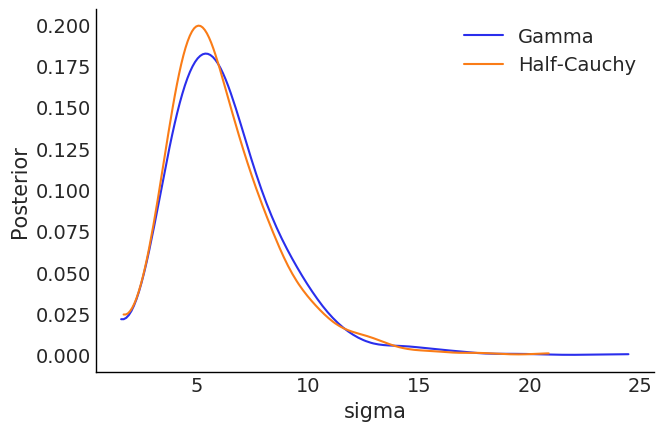

In [10]:
az.plot_kde((samples["τa"]) ** 2, label="Gamma")
az.plot_kde((samples_c["τa"] ** 2), label="Half-Cauchy", plot_kwargs={"color": "C1"})
plt.xlabel("sigma")
plt.ylabel("Posterior");

# Random effects

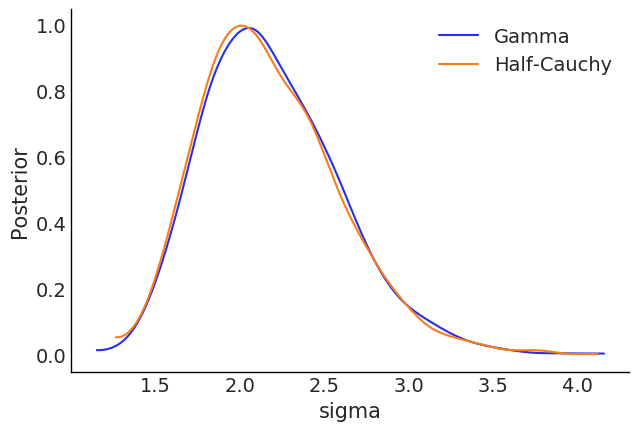

In [11]:
az.plot_kde((samples["τe"]) ** 2, label="Gamma")
az.plot_kde((samples_c["τe"] ** 2), label="Half-Cauchy", plot_kwargs={"color": "C1"})
plt.xlabel("sigma")
plt.ylabel("Posterior");

## Comparison with naive model

In addition to estimating random effects, random-effect models are useful to account for correlation between observations to obtain valid uncertainty estimates for model parameters. For example, say our objective is to estimate $\mu$. We could do this assuming all $n∗m=80$ observations are independent. But because we ignore dependence between repeated measurements for each subject, this inference is questionable.

In [12]:
with pm.Model() as model_0:
    # Priors
    μ = pm.Normal("μ", 0, 1000)
    τe = pm.HalfCauchy("τe", 1)
    # likelihood
    y_obs = pm.Normal("y_obs", μ, τe, observed=Y)
    samples_0 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [τe, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2025.05draws/s]
The acceptance probability does not match the target. It is 0.892796063001216, but should be close to 0.8. Try to increase the number of tuning steps.


In [13]:
mu = samples_c["μ"]
mu_naive = samples_0["μ"]

In [14]:
az.hpd(mu, credible_interval=0.95)

array([48.85916962, 51.11544684])

In [15]:
az.hpd(mu_naive, credible_interval=0.95)

array([49.42738857, 50.70654422])

In [16]:
np.var(mu) / np.var(mu_naive)

3.1827167977255644

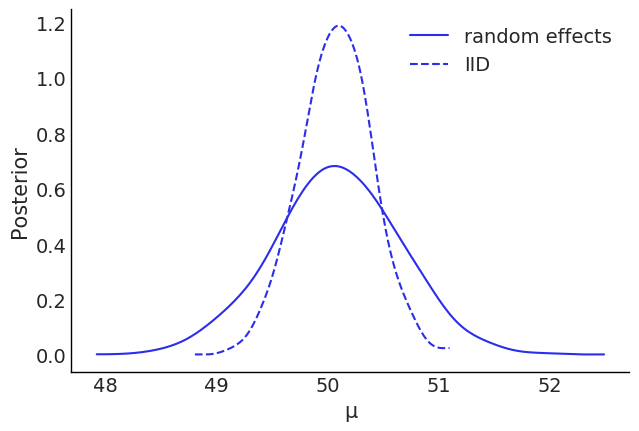

In [17]:
az.plot_kde(mu, label="random effects")
az.plot_kde(mu_naive, label="IID", plot_kwargs={"ls": "--"})
plt.xlabel("μ")
plt.ylabel("Posterior");